In [302]:
import numpy as np
import pandas as pd

In [303]:
import matplotlib.pyplot as plt
%matplotlib inline

In [304]:
df = pd.read_csv('train_clean.csv')

In [305]:
df.head()

,PassengerId,Survived,Pclass,Age,Cabin,Person,Family
0,1,0,3,22,NaN,male,1
1,2,1,1,38,C85,female,1
2,3,1,3,26,NaN,female,0
3,4,1,1,35,C123,female,1
4,5,0,3,35,NaN,male,0


For now, drop Cabin and don't worry about imputation.

In [306]:
del df['Cabin']

Important to remove categorical variables (male, female and child are not on a scale).

From analysis, it seems that Class and Person are categorical. Age can be fitted.

In [307]:
person_df = pd.get_dummies(df['Person'])
class_df = pd.get_dummies(df['Pclass'])
class_df.columns = ['First', 'Second', 'Third']
person_df.columns = ['Child', 'Female', 'Male']

In [308]:
df = pd.concat([df, person_df], axis=1)
df = pd.concat([df, class_df], axis=1)
del df['Person']
del df['Pclass']

df.head()

,PassengerId,Survived,Age,Family,Child,Female,Male,First,Second,Third
0,1,0,22,1,0,0,1,0,0,1
1,2,1,38,1,0,1,0,1,0,0
2,3,1,26,0,0,1,0,0,0,1
3,4,1,35,1,0,1,0,1,0,0
4,5,0,35,0,0,0,1,0,0,1


Need to take care of Multicollinearity from dummy variables.

In [309]:
df = df.drop(['PassengerId', 'Child', 'Third'], axis=1)

In [310]:
df.head()

,Survived,Age,Family,Female,Male,First,Second
0,0,22,1,0,1,0,0
1,1,38,1,1,0,1,0
2,1,26,0,1,0,0,0
3,1,35,1,1,0,1,0
4,0,35,0,0,1,0,0


In [311]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split

In [312]:
log_reg = LogisticRegression()

Take care of NaNs before fitting!

In [313]:
len(df)

891

In [314]:
pd.isnull(df).any()

Survived    False
Age          True
Family      False
Female      False
Male        False
First       False
Second      False
dtype: bool

In [315]:
df = df[df['Age'] < 120]

In [316]:
len(df)

714

In [317]:
pd.isnull(df).any()

Survived    False
Age         False
Family      False
Female      False
Male        False
First       False
Second      False
dtype: bool

In [318]:
Y = df.Survived
Y = np.ravel(Y)
Y[:10]

array([0, 1, 1, 1, 0, 0, 0, 1, 1, 1])

In [319]:
df.head()

,Survived,Age,Family,Female,Male,First,Second
0,0,22,1,0,1,0,0
1,1,38,1,1,0,1,0
2,1,26,0,1,0,0,0
3,1,35,1,1,0,1,0
4,0,35,0,0,1,0,0


In [320]:
df = df.drop(['Survived'], axis=1)

In [321]:
log_reg.fit(df, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [322]:
log_reg.score(df, Y)

0.80252100840336138

In [323]:
Y.mean()

0.4061624649859944

40.6% survived, so null error rate is 59.4%. 80.3% is a big increase.

In [324]:
coeff_df = pd.DataFrame(zip(df.columns, np.transpose(log_reg.coef_)))
coeff_df

,0,1
0,Age,[-0.0258036327191]
1,Family,[-0.305428722758]
2,Female,[0.85237675034]
3,Male,[-2.01440370828]
4,First,[2.42355630022]
5,Second,[1.12365026224]


We can say that Third class is least likely to survive in 'Class', (order: 1st > 2nd > 3rd) and that Female is most likely to survive in 'Gender' (order Female > Child > Male). Age is negatively correlated with survival, as seen in Fig. 11, coefficient seems small compared to the rest but note age is a continous variable from 0 to 90, not just 0 or 1. 

In [325]:
X_train, X_test, Y_train, Y_test = train_test_split(df, Y)

### Logistic Regression Model

In [326]:
log_reg = LogisticRegression()

log_reg.fit(X_train, Y_train)

Y_pred = log_reg.predict(X_test)

In [327]:
metrics.accuracy_score(Y_pred, Y_test)

0.82122905027932958

### KNN model

In [328]:
from sklearn.neighbors import KNeighborsClassifier

Find peak value for n_neighbors

In [329]:
accuracy = []

for k in range(1,40) :
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train, Y_train)
    Y_pred = KNN.predict(X_test)
    accuracy.append(metrics.accuracy_score(Y_pred, Y_test))

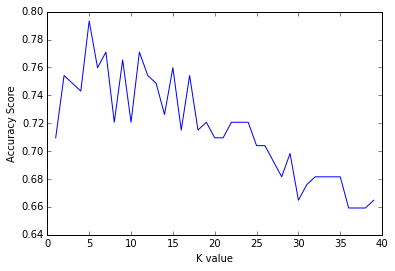

In [330]:
plt.plot(range(1,40), accuracy)
plt.xlabel('K value')
plt.ylabel('Accuracy Score')

In [331]:
K_peak = np.argmax(accuracy) + 1

In [332]:
KNN = KNeighborsClassifier(n_neighbors=K_peak)
KNN.fit(X_train, Y_train)
Y_pred = KNN.predict(X_test)
metrics.accuracy_score(Y_pred, Y_test)

0.79329608938547491

KNN and Logistic Regression are not much different in accuracy, logistic regression edges it (82.7% vs 78.8%).

### SVC model

In [333]:
from sklearn import svm
# Default 'rbf' is Gaussian
rbf_svc = svm.SVC()
rbf_svc.fit(X_train, Y_train)
Y_pred = rbf_svc.predict(X_test)
metrics.accuracy_score(Y_pred, Y_test)

0.83240223463687146

Again, about 80%. Some different kernels:

In [340]:
lin_svc = svm.SVC(kernel='linear').fit(X_train, Y_train)
pol_svc = svm.SVC(kernel='poly', degree=2).fit(X_train, Y_train)
lin2_svc = svm.LinearSVC().fit(X_train, Y_train)

In [341]:
Y_pred_lin = lin_svc.predict(X_test)
Y_pred_pol = pol_svc.predict(X_test)
Y_pred_lin2 = lin2_svc.predict(X_test)

In [342]:
lin_score = metrics.accuracy_score(Y_pred_lin, Y_test)
pol_score = metrics.accuracy_score(Y_pred_pol, Y_test)
lin2_score = metrics.accuracy_score(Y_pred_lin2, Y_test)

print lin_score, pol_score, lin2_score

0.815642458101 0.798882681564 0.59217877095


None as good as the Gaussian kernel

### Speed (Fitting and Predicting)

In [ ]:
%time KNN.fit(X_train, Y_train)
%time Y_pred = KNN.predict(X_test)

In [ ]:
%time log_reg.fit(X_train, Y_train)
%time Y_pred = log_reg.predict(X_test)

In [ ]:
%time svc.fit(X_train, Y_train)
%time Y_pred = svc.predict(X_test)

Logistic regression takes longer to fit (3.31ms vs 1.57ms) but takes less time to make predictions (513us vs 1.43us). SVC is slowest, comparable to KNN for predicting though.